# Processing of stress and wave data for UQ

In this notebook we analyze:

* Stress data derived from 3-d wind velocities at 20 Hz, measured by the sonic anemometer (IRGASON)
* Spectral and integrated wave quantities derived from water elevation time series at 20 Hz, measured by the ultrasonic distance meters (UDM)

## Goals

1. Explore the distributions of stress and wave quantities in different wind conditions
2. Find optimum time averaging periods for eddy-covariance and wave spectrum calculations
3. Explore the relationships between various wave quantities and stress

The ultimate goal is to build the conditional distribution of $-\overline{u'w'}$ given mean wind speed and several integrated wave properties:

$$
\mathcal{P}\left(-\overline{u'w'} | U, T_P, T_M, E, \chi^2 \right)
$$

This notebook focuses on a single experiment and two locations in the tank (IRGASON and UDM at 7 and 12 m fetch).
Once we develop the analysis pipeline, we'll feed data from other wind-only experiments and paddle conditions (monochromatic and JONSWAP waves).

## Experiment conditions

* Date: November 21, 2019
* Fresh water
* Mean water depth at start of experiment: 0.80 m
* Fan conditions: 0 - 60 Hz, at 5 Hz intervals
* Run length (for each fans speed): 600 s


In [128]:
from asist.utility import power_spectrum, cross_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.signal import detrend
from scipy.stats import beta, skew
from sustain_drag_2020.irgason import read_irgason_from_toa5, eddy_covariance_flux, rotate
from sustain_drag_2020.fetch import fetch
from sustain_drag_2020.dispersion import w2k
import warnings
warnings.filterwarnings('ignore')
import xarray as xr

import matplotlib
font = {'size': 16}
matplotlib.rc('font', **font)

In [108]:
def diffc(x):
    """Finite difference centered in space."""
    xx = np.zeros((x.size))
    xx[1:-1] = (x[2:] - x[:-2]) / 2
    xx[0] = x[1] - x[0]
    xx[-1] = x[-1] - x[-2]
    return xx

## Wind and stress data

### Loading raw data from files

In [110]:
# Wind-only, fresh water experiment 2019-11-21
ds = xr.open_dataset('sustain_drag_20191121.nc')

In [111]:
ds

<xarray.Dataset>
Dimensions:  (time: 156001)
Coordinates:
  * time     (time) float64 0.0 0.05 0.1 0.15 ... 7.8e+03 7.8e+03 7.8e+03
Data variables:
    fan      (time) float64 ...
    u1       (time) float64 ...
    u2       (time) float64 ...
    v1       (time) float64 ...
    v2       (time) float64 ...
    w1       (time) float64 ...
    w2       (time) float64 ...
    T1       (time) float64 ...
    T2       (time) float64 ...
    e1       (time) float64 ...
    e2       (time) float64 ...
    e3       (time) float64 ...
Attributes:
    experiment_name:      wind-only_fresh-water_20191121
    experiment_time:      2019-11-21_16:10:00
    water_type:           fresh
    initial_water_depth:  0.8
    institution:          University of Miami
    facility:             SUSTAIN Laboratory
    tank:                 SUSTAIN
    contact:              Milan Curcic <mcurcic@miami.edu>

## Raw velocities

Text(0.5, 0.98, 'IRGASON 1')

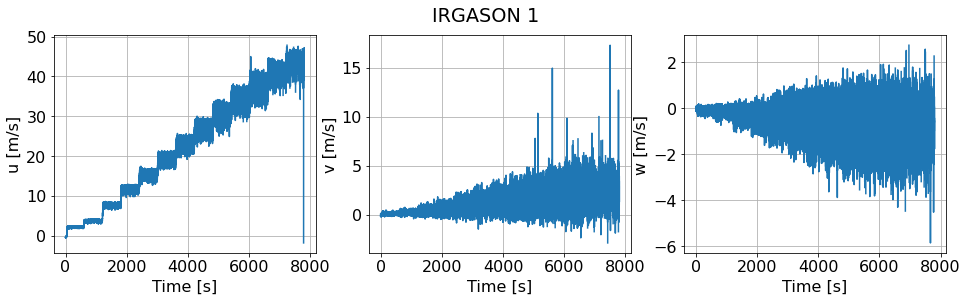

In [115]:
fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(ds.time, ds.u1)
ax2.plot(ds.time, ds.v1)
ax3.plot(ds.time, ds.w1)
ax1.set_ylabel('u [m/s]')
ax2.set_ylabel('v [m/s]')
ax3.set_ylabel('w [m/s]')
for ax in [ax1, ax2, ax3]:
    ax.grid()
    ax.set_xlabel('Time [s]')
fig.suptitle('IRGASON 1')

Text(0.5, 0.98, 'IRGASON 2')

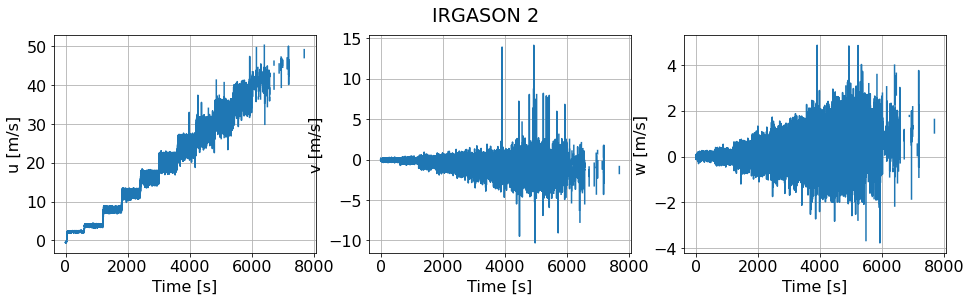

In [116]:
fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(ds.time, ds.u2)
ax2.plot(ds.time, ds.v2)
ax3.plot(ds.time, ds.w2)
ax1.set_ylabel('u [m/s]')
ax2.set_ylabel('v [m/s]')
ax3.set_ylabel('w [m/s]')
for ax in [ax1, ax2, ax3]:
    ax.grid()
    ax.set_xlabel('Time [s]')
fig.suptitle('IRGASON 2')

## Universal spectra

In [156]:
# fan speed and duration and sampling interval
run_seconds = 600
num_runs = len(fan)
offset = 30
z = 0.65

In [157]:
fan = range(0, 30, 5)
nfan = len(fan)
nfreq = 90
Suu = np.zeros((nfan, nfreq))
Sww = np.zeros((nfan, nfreq))
Suw = np.zeros((nfan, nfreq))
U = np.zeros((nfan))
uw = np.zeros((nfan))
sigma_u = np.zeros((nfan))
sigma_w = np.zeros((nfan))

In [158]:
for n, fan_speed in enumerate(fan):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time < t1)
    u, v, w = np.array(ds.u1)[mask], np.array(ds.v1)[mask], np.array(ds.w1[mask]) 
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    if np.any(np.isnan(u)):
        break
    U[n] = np.mean(u)
    up, wp = detrend(u), detrend(w)
    Suu[n,:], Sww[n,:], Suw[n,:], phase, coherence, f, df = cross_spectrum(up, wp, 1 / 20, binsize=64)
    df = diffc(f)[0]
    sigma_u[n], sigma_w[n] = np.std(u), np.std(w)
    uw[n] = np.mean(up * wp)

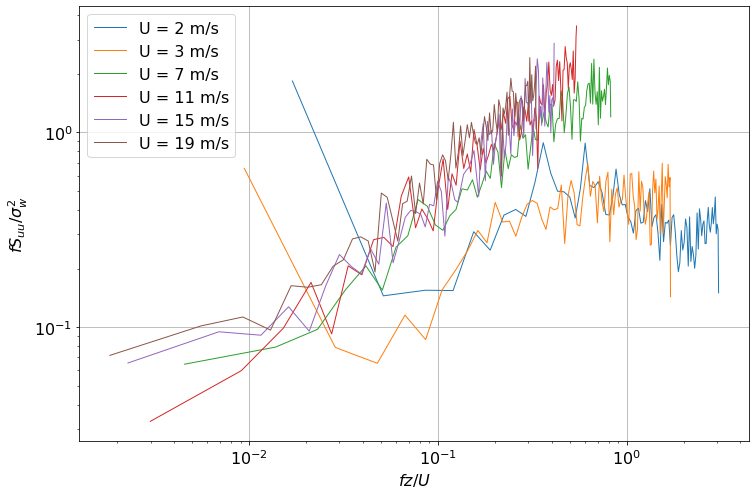

In [145]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    plt.loglog(f * z / U[n], f * Suu[n,:] / sigma_w[n]**2, lw=1, label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{uu}/\sigma^2_w$')
plt.grid()

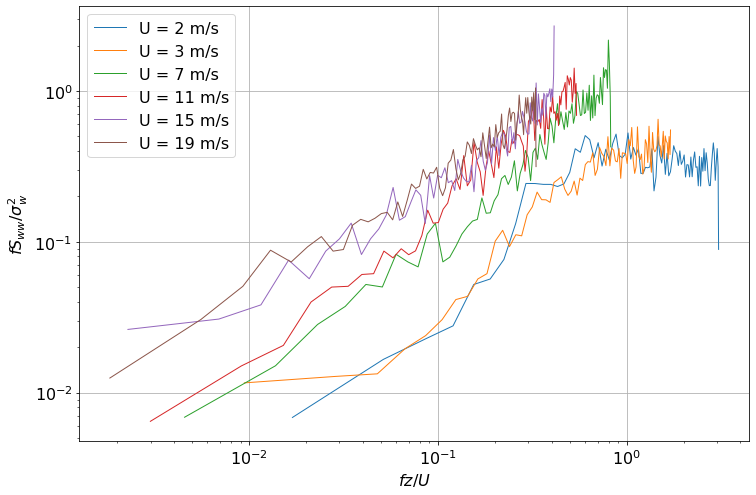

In [146]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    plt.loglog(f * z / U[n], f * Sww[n,:] / sigma_w[n]**2, lw=1, label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{ww}/\sigma^2_w$')
plt.grid()

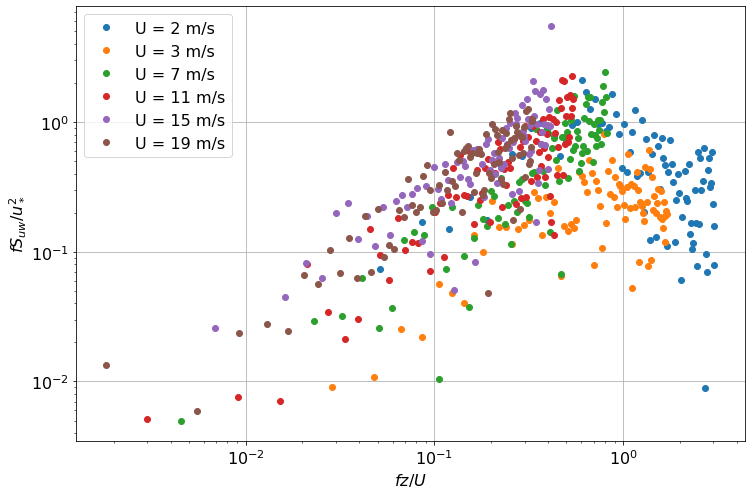

In [169]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    plt.loglog(f * z / U[n], f * Suw[n,:] / uw[n], marker='.', ms=12, linestyle='', label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{uw}/u^2_*$')
plt.grid()

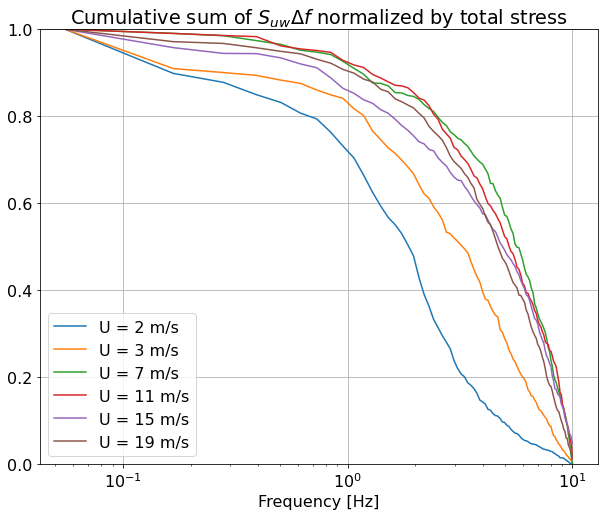

In [179]:
fig = plt.figure(figsize=(10, 8))
for n in range(len(uw)):
    plt.semilogx(f[::-1], np.cumsum(np.abs(Suw[n,::-1]) * df) / np.sum(np.abs(Suw[n,::-1]) * df), label='U = %i m/s' % U[n])
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylim(0, 1)
plt.title('Cumulative sum of $S_{uw} \Delta f$ normalized by total stress')
plt.grid()

## Velocity distributions

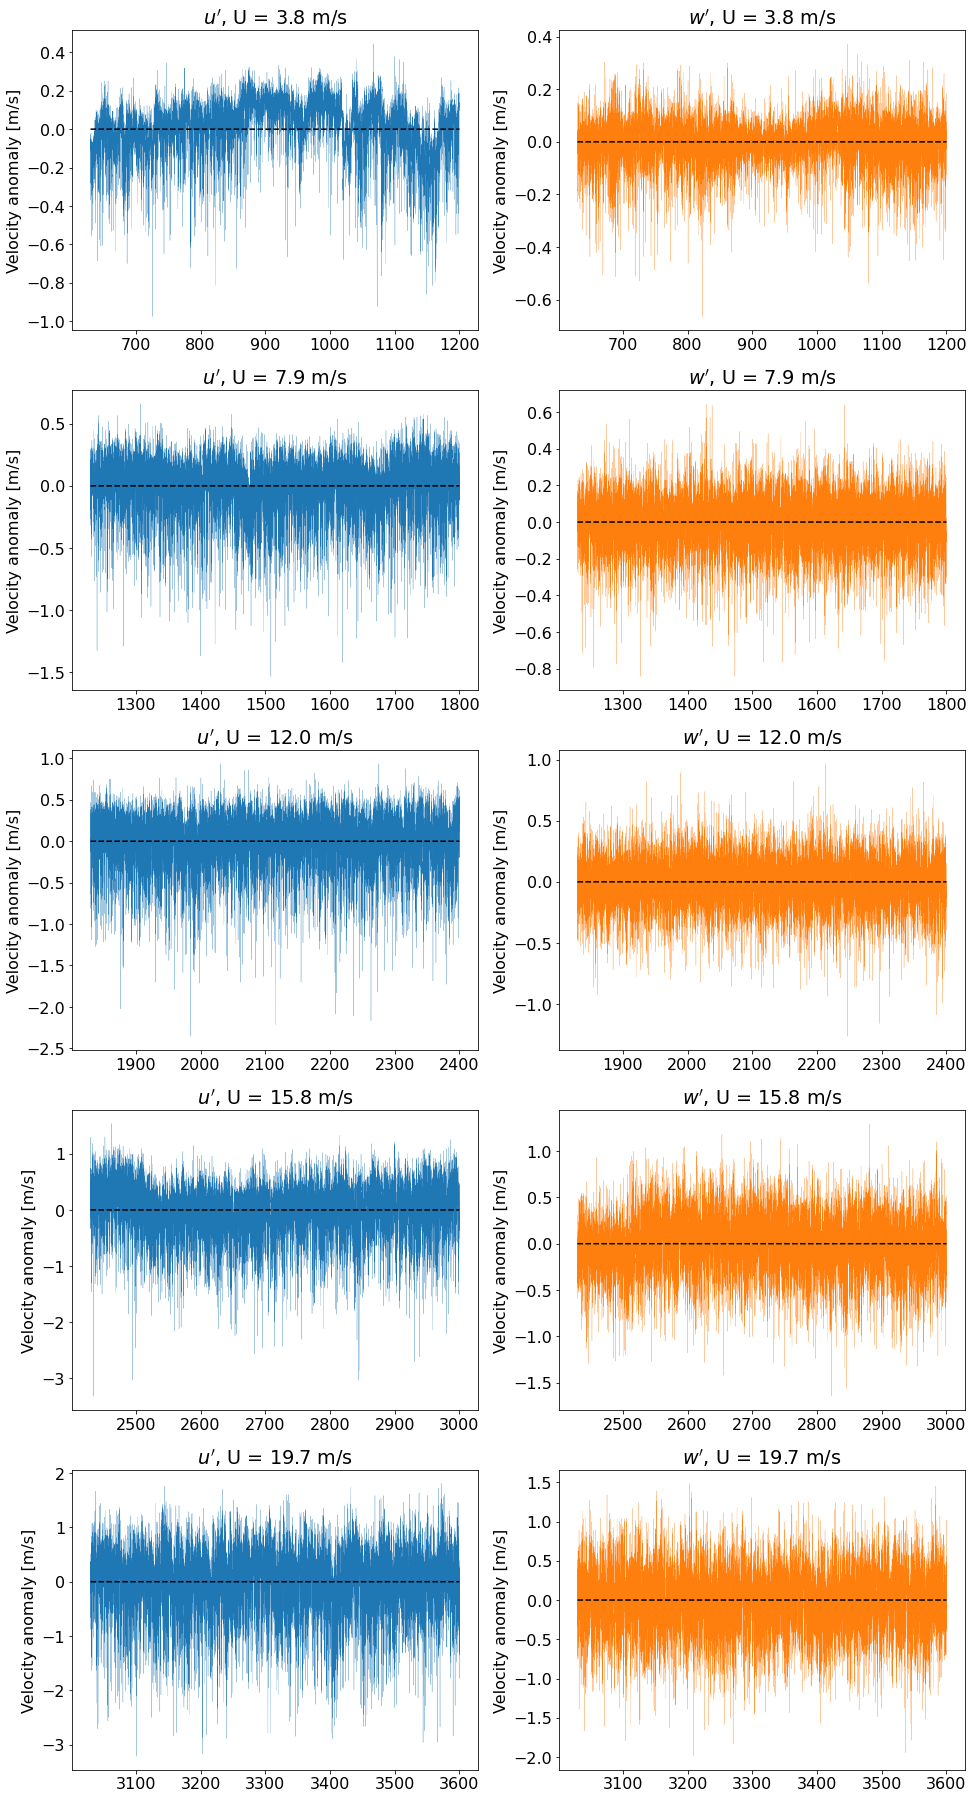

In [105]:
fig = plt.figure(figsize=(16, 32))
for n, fan_speed in enumerate(fan):
    if n == 0:
        continue
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time < t1)
    time = ds.time[mask]
    u, v, w = np.array(ds.u1)[mask], np.array(ds.v1)[mask], np.array(ds.w1[mask]) 
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U = np.mean(u)
    up, wp = detrend(u), detrend(w)
    ax1 = plt.subplot2grid((5, 2), (n-1, 0))
    ax2 = plt.subplot2grid((5, 2), (n-1, 1))
    ax1.plot(time, up, color='tab:blue', lw=0.2)
    ax2.plot(time, wp, color='tab:orange', lw=0.2)
    for ax in [ax1, ax2]:
        ax.set_ylabel('Velocity anomaly [m/s]')
        ax.plot(time, 0 * time, 'k--')
    ax1.set_title(r"$u'$, U = %.1f m/s" % U)
    ax2.set_title(r"$w'$, U = %.1f m/s" % U)

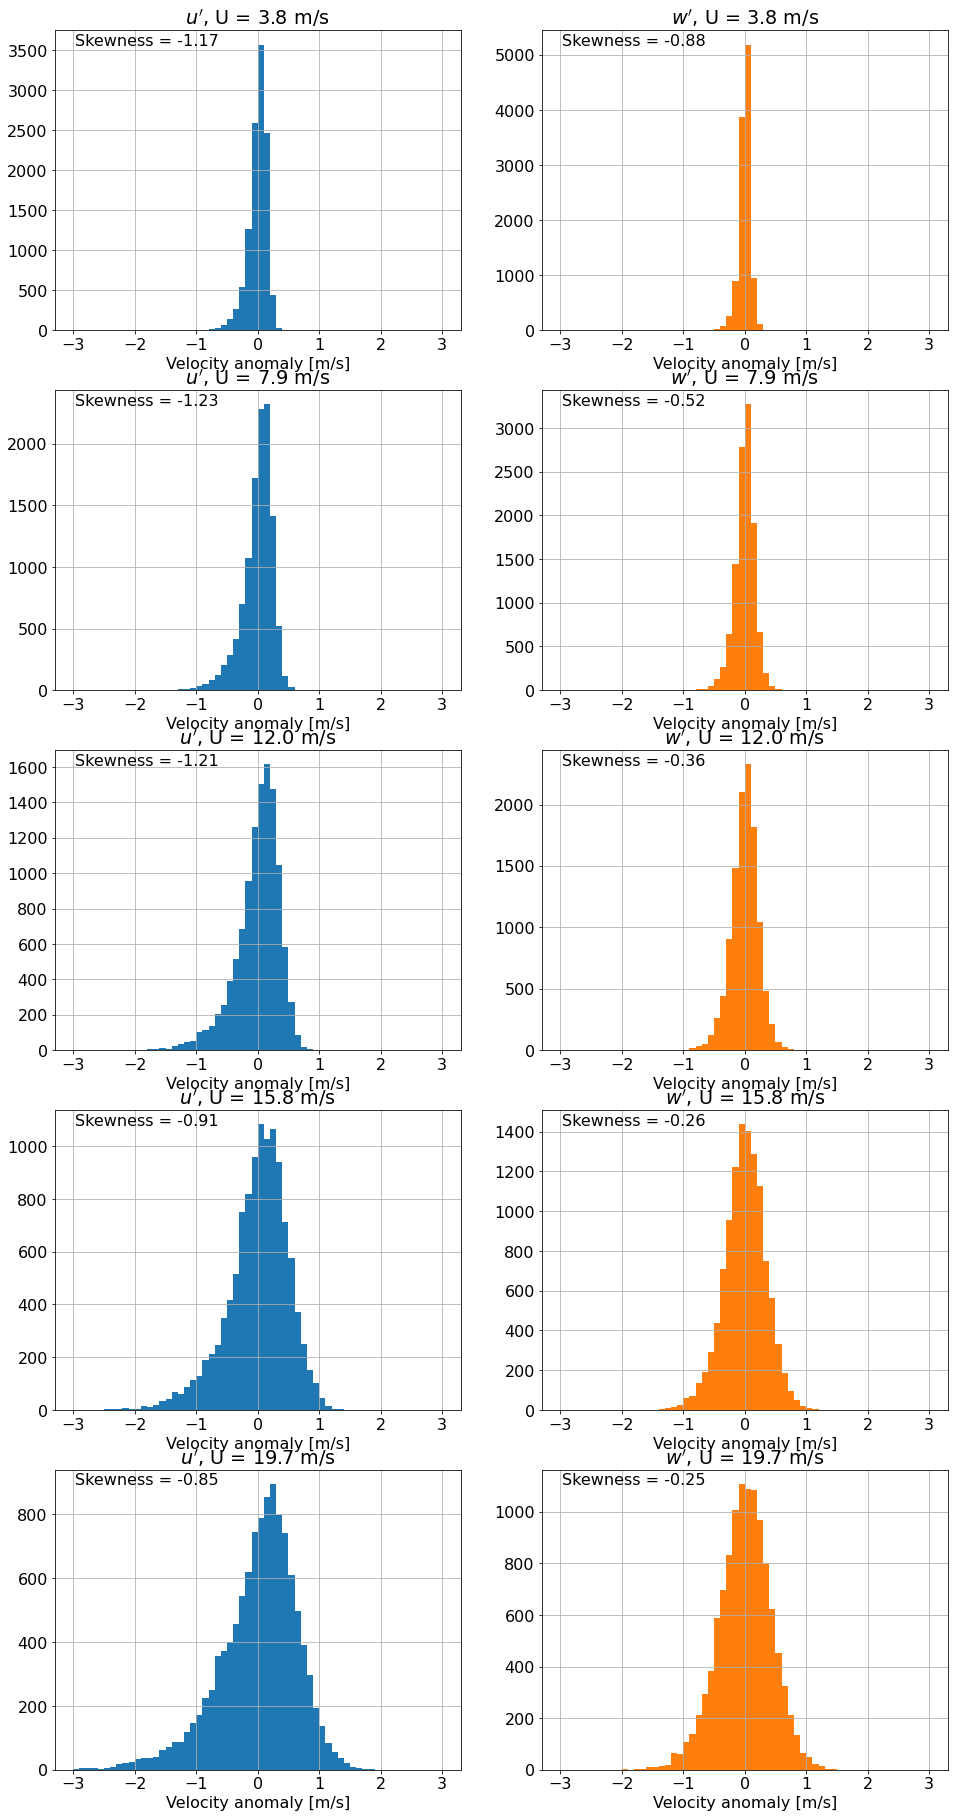

In [134]:
U, skewu, skeww = [], [], []

fig = plt.figure(figsize=(16, 32))
for n, fan_speed in enumerate(fan):
    if n == 0:
        continue
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time < t1)
    time = ds.time[mask]
    u, v, w = np.array(ds.u1)[mask], np.array(ds.v1)[mask], np.array(ds.w1[mask]) 
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U.append(np.mean(u))
    up, wp = detrend(u), detrend(w)
    skewu.append(skew(up))
    skeww.append(skew(wp))
    ax1 = plt.subplot2grid((5, 2), (n-1, 0))
    ax2 = plt.subplot2grid((5, 2), (n-1, 1))
    ax1.hist(up, bins=np.arange(-3, 3.1, 0.1), color='tab:blue')
    ax2.hist(wp, bins=np.arange(-3, 3.1, 0.1), color='tab:orange')
    ax1.set_title(r"$u'$, U = %.1f m/s" % U[n-1])
    ax2.set_title(r"$w'$, U = %.1f m/s" % U[n-1])
    ax1.text(0.05, 0.95, 'Skewness = %.2f' % skew(up), transform=ax1.transAxes)
    ax2.text(0.05, 0.95, 'Skewness = %.2f' % skew(wp), transform=ax2.transAxes)
    for ax in [ax1, ax2]:
        ax.grid()
        ax.set_xlabel('Velocity anomaly [m/s]')

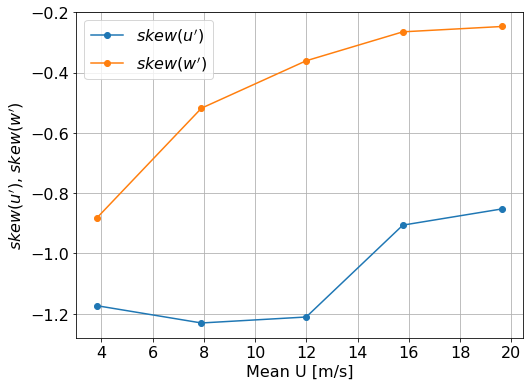

In [139]:
plt.figure(figsize=(8, 6))
plt.plot(U, skewu, marker='o', label=r"$skew(u')$")
plt.plot(U, skeww, marker='o', label=r"$skew(w')$")
plt.legend()
plt.xlabel('Mean U [m/s]')
plt.ylabel(r"$skew(u')$, $skew(w')$")
plt.grid()

### Computing stress from raw velocity time series

We'll compute the stress from raw velocity time series using the eddy-covariance (EC) method.

For each run, we can sample the time series sequentially or randomly. 
Sequential sampling yields a fixed number of possible samples ($T_{run} / T_{sample}$), 
whereas with random sampling we can sample any number of data segments,
although with the caveat that past some number of samples we'd be oversampling the time series.

In [197]:
def eddy_covariance_flux(u_, v_, w_, time, t0, t1):
    """Eddy covariance flux for a time subset between t0 and t1."""
    mask = (time >= t0) & (time <= t1)
    u, v, w = u_[mask], v_[mask], w_[mask]
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U, W = np.nanmean(u), np.nanmean(w) # time mean
    up, wp = u - U, w - W # deviations from the mean
    uw = np.nanmean(up * wp) # stress
    good = ~np.isnan(u) & ~np.isnan(w)
    perc_good = (u[good].size / u.size) * 100
    return U, uw, perc_good

In [198]:
def sample_stress(u, v, w, time, run_seconds, sample_seconds, sampling, offset=30):
    """Uniform-randomly sample IRGASON data and compute stress over given sample intervals."""
    num_runs, num_samples = sampling.shape
    U = np.zeros(sampling.shape)
    uw = np.zeros(sampling.shape)
    perc_good = np.zeros((num_runs, num_samples))
    for n in range(num_runs):
        print('Computing stress for run', n)
        for i in range(num_samples):
            t0 = n * run_seconds + sampling[n,i]
            t1 = t0 + sample_seconds
            U[n,i], uw[n,i], perc_good[n,i] = eddy_covariance_flux(u, v, w, time, t0, t1)
    return U, uw, perc_good

In [199]:
# fan speed and duration and sampling interval
fan = range(0, 65, 5)
run_seconds = 600
sample_seconds = 10
num_runs = len(fan)
num_samples = 120
sampling = np.random.uniform(size=(num_runs, num_samples)) * (run_seconds - sample_seconds)

In [200]:
U, uw, percent_good = sample_stress(ds.u1, ds.v1, ds.w1, ds.time, run_seconds, sample_seconds, sampling)

Computing stress for run 0
Computing stress for run 1
Computing stress for run 2
Computing stress for run 3
Computing stress for run 4
Computing stress for run 5
Computing stress for run 6
Computing stress for run 7
Computing stress for run 8
Computing stress for run 9
Computing stress for run 10
Computing stress for run 11
Computing stress for run 12


Text(0.5, 1.0, 'IRGASON 1')

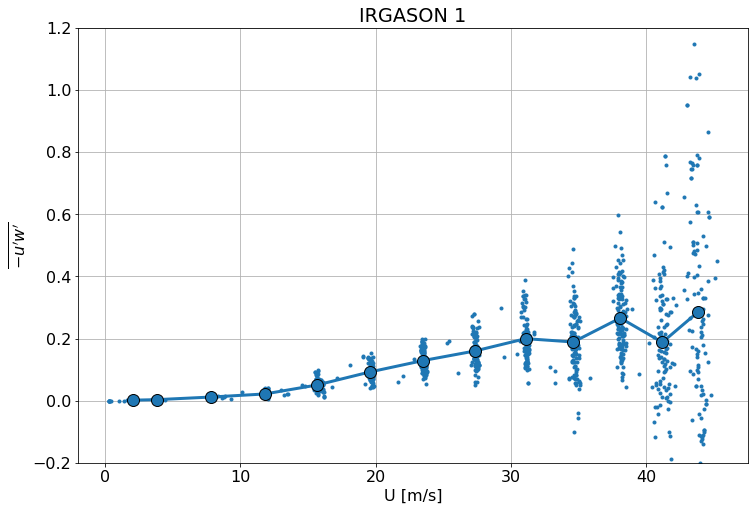

In [207]:
plt.figure(figsize=(12, 8))
plt.plot(U, uw, marker='o', ms=3, color='tab:blue', linestyle='')
plt.plot(np.mean(U, 1), np.mean(uw, 1), marker='o', ms=12, color='tab:blue', lw=3, mec='k')
plt.ylim(-0.2, 1.2)
plt.grid()
plt.xlabel('U [m/s]')
plt.ylabel(r"$\overline{-u'w'}$")
plt.title('IRGASON 1')

Text(0, 0.5, 'Percentage of good data')

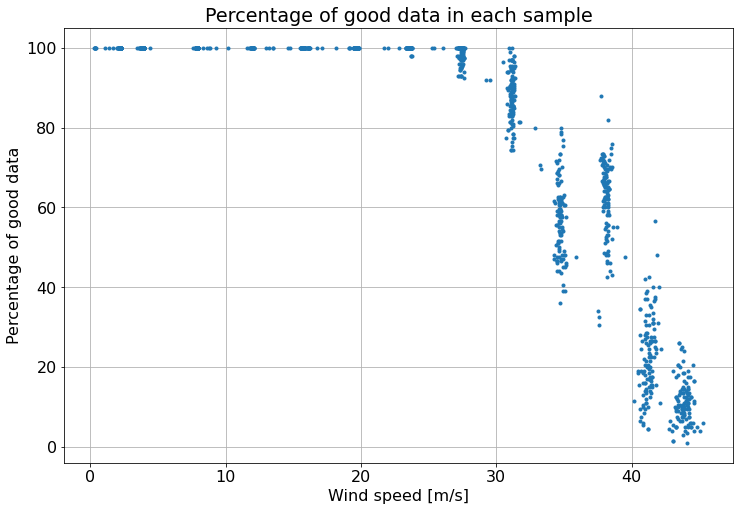

In [231]:
plt.figure(figsize=(12, 8))
plt.plot(U, percent_good, 'k.', color='tab:blue')
plt.title('Percentage of good data in each sample')
plt.grid()
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Percentage of good data')

In [213]:
def normalize(x):
    """Normalize array x to (0, 1) (exclusive) range."""
    xnorm = (x - np.min(x)) / (np.max(x) - np.min(x))
    xnorm[xnorm < 1e-6] = 1e-6
    xnorm[xnorm > 1 - 1e-6] = 1 - 1e-6
    return xnorm


def moments_fit(x):
    """Fitting a Beta distribution using a moments approach."""
    xmean = np.mean(x)
    xvar = np.var(x)
    alpha = xmean * (xmean * (1 - xmean) - xvar) / xvar
    beta = (xmean - 1) * (xmean * (xmean - 1) + xvar) / xvar
    return alpha, beta


def beta_pdf(x, fitting_type='mle', floc=0, fscale=1):
    """Returns alpha and beta parameters from a beta distribution."""
    num_runs = x.shape[0]
    aa = np.zeros((num_runs))
    bb = np.zeros((num_runs))
    for n in range(num_runs):
        xnorm = normalize(x[n,:][~np.isnan(x[n,:])])
        if fitting_type == 'mle':
            aa[n], bb[n], loc, scale = beta.fit(xnorm, floc=floc, fscale=fscale)
        elif fitting_type == 'moments':
            aa[n], bb[n] = moments_fit(xnorm)
        else:
            raise ValueError('fitting_type not supported')
    return aa, bb


def dist_ks(x, alpha, beta):
    """Kolmogorov-Smirnoff distance. Not used yet."""
    x_sorted = np.sort(x)
    cdf = beta.cdf(x, alpha, beta)
    xx = np.linspace(1 / x.size, 1, x.size)
    series1 = np.abs(cdf - xx)
    series2 = np.abs(cdf - xx + 1 / x.size)
    return np.max(np.max(series1), np.max(series2))

## Stress distributions

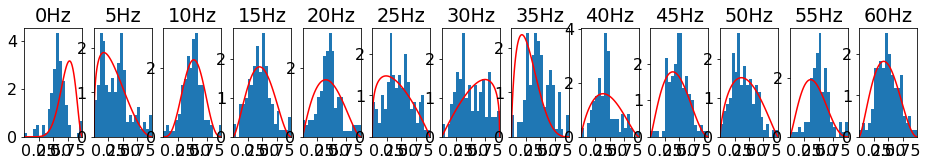

In [215]:
aa, bb = beta_pdf(uw1, 'moments')

fig = plt.figure(figsize=(16, 2))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    data = normalize(uw[n,:][~np.isnan(uw[n,:])])
    plt.hist(data, 20, density=True)
    x = np.linspace(0, 1, 100)
    plt.plot(x, beta.pdf(x, aa[n], bb[n]), 'r-')
    plt.xlim(np.min(data), np.max(data))
    plt.title(str(fan[n]) + 'Hz')

Text(0, 0.5, "$-\\overline{u'w'}$ [$m^2/s^2$]")

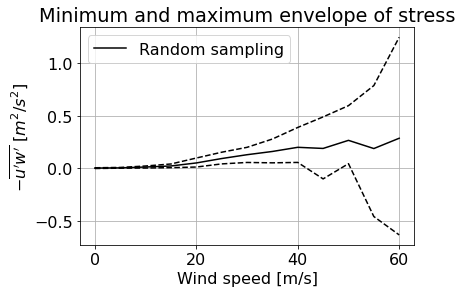

In [216]:
plt.plot(fan, np.min(uw, axis=1), 'k--')
plt.plot(fan, np.max(uw, axis=1), 'k--')
plt.plot(fan, np.mean(uw, axis=1), 'k-', label='Random sampling')
plt.legend()
plt.grid()
plt.title('Minimum and maximum envelope of stress')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")

## Processing waves from wave-wire

In [217]:
# 10-minute time windows for each run; 
t0 = [n * run_seconds for n in range(len(fan))]
t1 = [t0[n] + run_seconds for n in range(len(fan))]

Computing wave spectra for fan speed  5 Hz
Computing wave spectra for fan speed  10 Hz
Computing wave spectra for fan speed  15 Hz
Computing wave spectra for fan speed  20 Hz
Computing wave spectra for fan speed  25 Hz
Computing wave spectra for fan speed  30 Hz
Computing wave spectra for fan speed  35 Hz
Computing wave spectra for fan speed  40 Hz
Computing wave spectra for fan speed  45 Hz
Computing wave spectra for fan speed  50 Hz
Computing wave spectra for fan speed  55 Hz
Computing wave spectra for fan speed  60 Hz


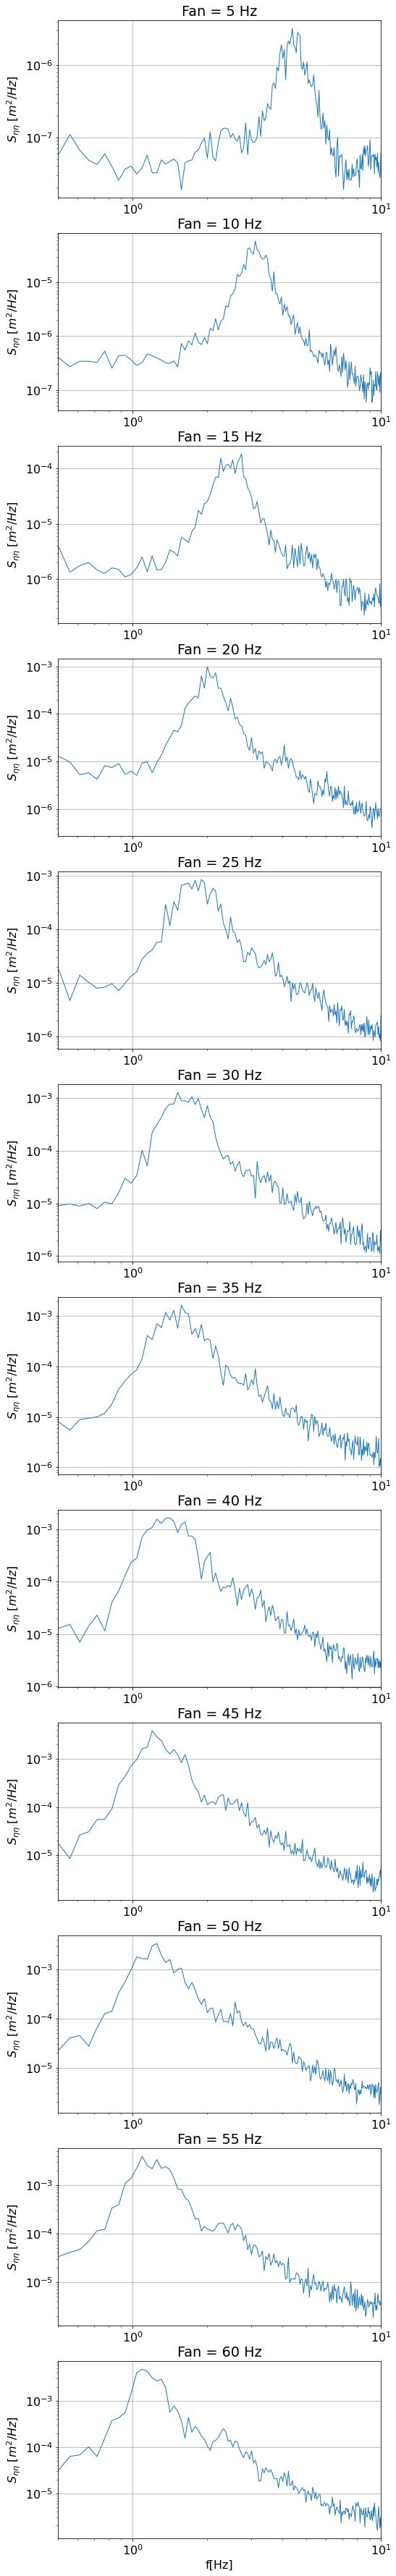

In [230]:
fig = plt.figure(figsize=(8, 64))
for n in range(1, len(fan)):
    print('Computing wave spectra for fan speed ', fan[n], 'Hz')
    mask = (ds.time >= t0[n]) & (ds.time <= t1[n])
    ax = plt.subplot2grid((12, 1), (n - 1, 0))
    e = detrend(ds.e1[mask])
    F, f, df = power_spectrum(e, 1 / 20, binsize=32)
    ax.loglog(f, F, lw=1)
    plt.xlim(0.5, 1e1)
    plt.title('Fan = %i Hz' % fan[n])
    plt.ylabel('$S_{\eta\eta}$ [$m^2/Hz$]')
    plt.grid()
    if n == len(fan) - 1: plt.xlabel('f[Hz]')

In [219]:
def integrated_wave_properties_from_wavewire(time, elev, num_runs, num_samples, sampling):

    E = np.zeros((num_runs, num_samples))
    Ek = np.zeros((num_runs, num_samples))
    mss = np.zeros((num_runs, num_samples))
    Tm = np.zeros((num_runs, num_samples))
    Tp = np.zeros((num_runs, num_samples))

    for n in range(num_runs):
        print('Computing wave spectra for run ', n)
        for i in range(num_samples):
            t0 = n * run_seconds + sampling[n,i]
            t1 = t0 + sample_seconds
            mask = (time >= t0) & (time < t1)
            e = detrend(elev[mask])
            F, f, df = power_spectrum(e, 1 / 20, binsize=1)
            k = w2k(2 * np.pi * f)[0]
            dk = diffc(k)
            Fk = F * df / dk
            E[n,i] = np.sum(F) * df
            Ek[n,i] = np.sum(Fk * dk)
            fmask = f >= 0.5
            mss[n,i] = np.sum(Fk[fmask] * k[fmask]**2 * dk[fmask]) / (2 * np.pi)**3
            Tm[n,i] = np.sum(F[fmask]) / np.sum(F[fmask] * f[fmask])
            Tp[n,i] = np.sum(F[fmask]**4) / np.sum(F[fmask]**4 * f[fmask])
            
    return E, mss, Tm, Tp

In [220]:
E, mss, Tm, Tp = integrated_wave_properties_from_wavewire(ds.time, ds.e1, num_runs, num_samples, sampling)

Computing wave spectra for run  0
Computing wave spectra for run  1
Computing wave spectra for run  2
Computing wave spectra for run  3
Computing wave spectra for run  4
Computing wave spectra for run  5
Computing wave spectra for run  6
Computing wave spectra for run  7
Computing wave spectra for run  8
Computing wave spectra for run  9
Computing wave spectra for run  10
Computing wave spectra for run  11
Computing wave spectra for run  12


Text(0, 0.5, 'Stress [m^2/s^2]')

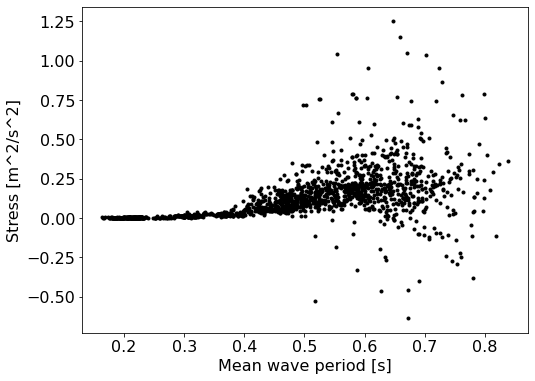

In [229]:
fig = plt.figure(figsize=(8, 6))
plt.plot(Tm, uw, 'k.')
plt.xlabel('Mean wave period [s]')
plt.ylabel('Stress [m^2/s^2]')

Text(0.5, 1.0, 'Wave energy [$m^2$], fetch = 7 m')

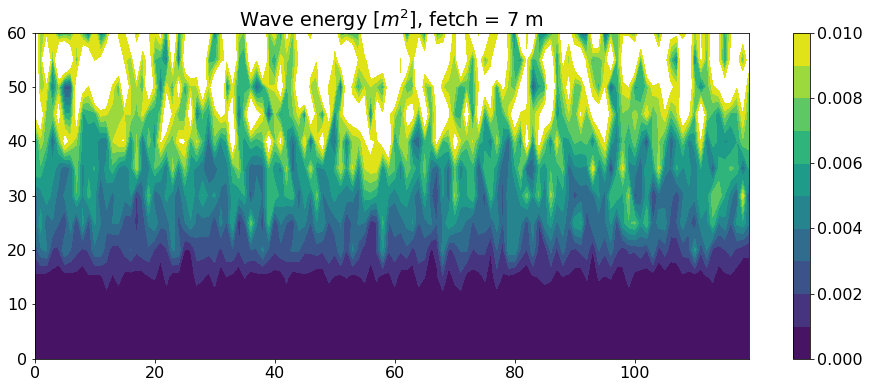

In [226]:
fig = plt.figure(figsize=(16, 6))
plt.contourf(range(num_samples), fan, E, np.arange(0, 0.011, 0.001))
plt.colorbar()
plt.title('Wave energy [$m^2$], fetch = 7 m')

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
c1 = ax1.contourf(range(num_samples), fan, Tm1, np.arange(0, 0.61, 0.01))
fig.colorbar(c1, ax=ax1)
c2 = ax2.contourf(range(num_samples), fan, Tm2, np.arange(0, 0.61, 0.01))
fig.colorbar(c2, ax=ax2)
for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlabel('Samples')
    ax.set_ylabel('Fan [Hz]')
ax1.set_title('Mean period [$s$], fetch = 7 m')
ax2.set_title('Mean period [$s$], fetch = 12 m')

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
c1 = ax1.contourf(range(num_samples), fan, Tp1, np.arange(0, 1.01, 0.01))
fig.colorbar(c1, ax=ax1)
c2 = ax2.contourf(range(num_samples), fan, Tp2, np.arange(0, 1.01, 0.01))
fig.colorbar(c2, ax=ax2)
for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlabel('Samples')
    ax.set_ylabel('Fan [Hz]')
ax1.set_title('Peak period [$s$], fetch = 7 m')
ax2.set_title('Peak period [$s$], fetch = 12 m')

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
c1 = ax1.contourf(range(num_samples), fan, mss1, np.arange(0, 0.21, 0.01))
fig.colorbar(c1, ax=ax1)
c2 = ax2.contourf(range(num_samples), fan, mss2, np.arange(0, 0.21, 0.01))
fig.colorbar(c2, ax=ax2)
for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlabel('Samples')
    ax.set_ylabel('Fan [Hz]')
ax1.set_title('Mean square slope, fetch = 7 m')
ax2.set_title('Mean square slope, fetch = 12 m')

In [ ]:
plt.plot(U1, E1, 'k.', ms=1)
plt.plot(np.nanmean(U1, 1), np.nanmedian(E1, 1), 'k-', marker='o', mec='k', label='Fetch = 7 m')
plt.plot(U2, E2, 'r.', ms=1)
plt.plot(np.nanmean(U2, 1), np.nanmedian(E2, 1), 'r-', marker='o', mec='k', label='Fetch = 12 m')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r'Wave energy [$m^2$]')
plt.ylim(0, 0.02)
plt.grid()
plt.legend()

In [ ]:
plt.plot(U1, Tm1, 'k.', ms=1)
plt.plot(np.nanmean(U1, 1), np.nanmedian(Tm1, 1), 'k-', marker='o', mec='k', label='Fetch = 7 m')
plt.plot(U2, Tm2, 'r.', ms=1)
plt.plot(np.nanmean(U2, 1), np.nanmedian(Tm2, 1), 'r-', marker='o', mec='k', label='Fetch = 12 m')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r'Mean period [$s$]')
plt.ylim(0, 0.8)
plt.grid()
plt.legend()

In [ ]:
plt.plot(U1, Tp1, 'k.', ms=1)
plt.plot(np.nanmean(U1, 1), np.nanmedian(Tp1, 1), 'k-', marker='o', mec='k', label='Fetch = 7 m')
plt.plot(U2, Tp2, 'r.', ms=1)
plt.plot(np.nanmean(U2, 1), np.nanmedian(Tp2, 1), 'r-', marker='o', mec='k', label='Fetch = 12 m')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r'Peak period [$s$]')
plt.ylim(0, 1.2)
plt.grid()
plt.legend()

In [ ]:
plt.plot(U1, mss1, 'k.', ms=1)
plt.plot(np.nanmean(U1, 1), np.nanmedian(mss1, 1), 'k-', marker='o', mec='k', label='Fetch = 7 m')
plt.plot(U2, mss2, 'r.', ms=1)
plt.plot(np.nanmean(U2, 1), np.nanmedian(mss2, 1), 'r-', marker='o', mec='k', label='Fetch = 12 m')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r'Mean square slope')
plt.ylim(0, 0.2)
plt.grid()
plt.legend()

In [ ]:
print('Correlation coefficient between stress and wind speed')
good = ~np.isnan(uw1)

corr = np.nan * np.zeros((6, 6))
for m, var1 in enumerate([uw1, U1**2, E1, Tm1, Tp1, mss1]):
    for n, var2 in enumerate([uw1, U1**2, E1, Tm1, Tp1, mss1]):
        if m <= n:
            corr[m,n] = np.corrcoef(var1[good], var2[good])[0,1]

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.pcolor(corr)
plt.colorbar()
for m in range(6):
    for n in range(6):
        if m <= n:
            plt.text(n + 0.5, m + 0.5, '%.2f' % corr[m,n], va='center', ha='center')
ax.set_xticks = np.arange(0.5, 6.5, 1)
ax.set_yticks = np.arange(0.5, 6.5, 1)
labels = [r"$\overline{u'w'}$", r'$U^2$', r'$E$', r'$T_M$', r'$T_P$', r'$\chi^2$']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.grid()